In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from mhm_dataprocessing import *

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'

### Read data

In [4]:
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States.nc")

#shapefile mask
be_shp = gpd.read_file(r"W:\VUB\_main_research\mHM\mhm_belgium\be_shp\be.shp")

In [5]:
be_data = clip_to_region(be_shp, mhm_fluxes)

#resample to month ends
#resample fluxes to month ends
variables = ['SM_L01','SM_L02','SM_L03','SM_Lall','SWC_L01','SWC_L02','SWC_L03','recharge']

mhm_fluxes_mon= be_data[variables].resample(time='ME').mean()

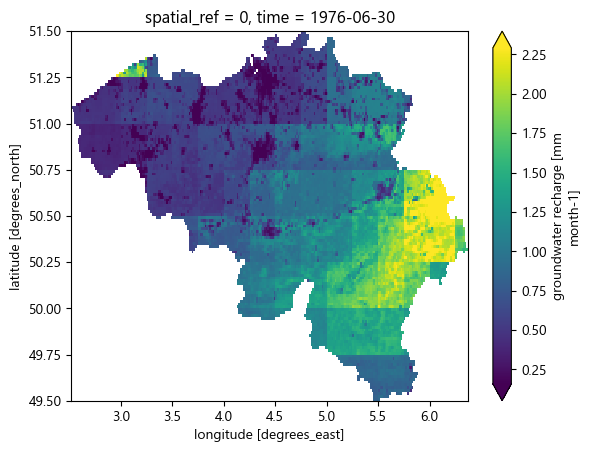

In [6]:
mhm_fluxes_mon['recharge'][77].plot(robust=True)

In [9]:
#select values for June
data=mhm_fluxes_mon.sel(time=mhm_fluxes_mon.time.dt.month==6)

#select a time series from a specific location
sample_ts = mhm_fluxes_mon['SM_Lall'].sel(lon=4.5, lat=50.5, method='nearest')

In [10]:
ts_df = sample_ts.to_dataframe().drop(columns=['lat', 'lon'])

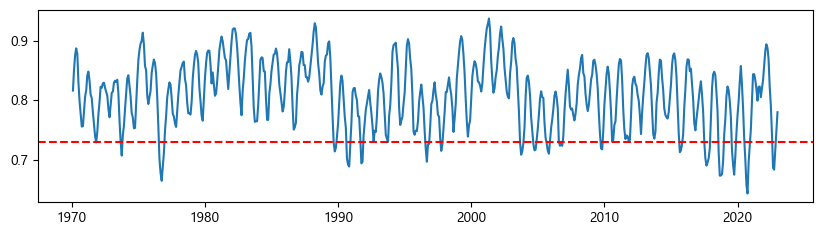

In [11]:
fig,ax=plt.subplots(figsize=(10,2.5))
plt.plot(ts_df.index, ts_df['SM_Lall'])
plt.axhline(y=0.73, color='r', linestyle='--')

#### SMI and drought characteristics

ref: https://www.nature.com/articles/s41558-018-0138-5

$SMI_{t} = F_{T}(x_{t})$


 Represents the quantile at the soil moisture fraction value x (normalized against the saturated soil water content). x t denotes the simulated monthly soil moisture fraction at a time t and is the empirical distribution function estimated using the kernel density estimator, $f_{t}(x)$

 $f_{t}(x) = \frac{1}{nh}\sum_{k=1}^{n}K(\frac{x-x_{k}}{h})$
  

 Here, $x_{1}$, …, $x_{n}$ n represents the simulated soil moisture fraction of a given calendar month during the reference period T; n denotes the number of calendar months within a given period (that is, 30 for a 30-year period); and $K$ represents a Gaussian kernel function with a bandwidth h. The bandwidth is estimated with GridSearch.
 
$K(x, x_{k}) = \frac{1}{\sqrt{2\pi h^{2}}}\exp(\frac{(x-x_{k})^{2}}{2h^{2}})$

A cell at time t is under drought when $SMI_{t}$  < $\tau$. Here, $\tau$ denotes that the soil water content in this cell is less than the values occurring $\tau$ × 100% of the time. In this study, \tau is set to 0.2
 

  
### Bandwidth selection
Find the optimal bandwidth h for the distribution function.
GridsearchCV

-- --
Alternatively using Silverman's rule (has limitations)


https://towardsdatascience.com/bounded-kernel-density-estimation-2082dff3f47f

Silverman's rule of thumb, optimal when the underlying density being estimated is Gaussian

$h = \sigma * (\frac{4}{3n})^{-0.2}$

#### Kernel Density Estimation (Example)

Optimal bandwidth: 0.020817635270541084


Text(0, 0.5, 'Probability Density')

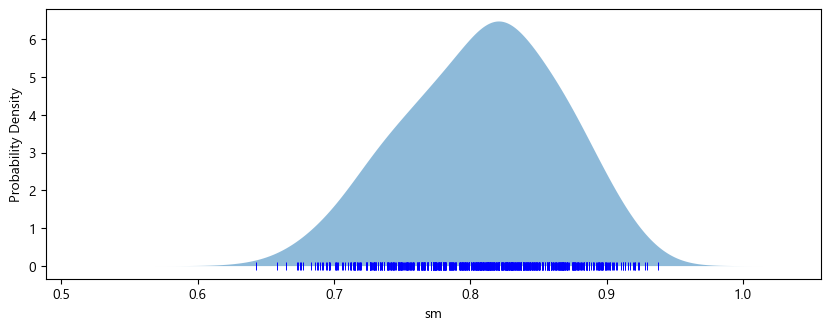

In [13]:
#GridSearchCV to find the optimal bandwidth
#extract values
soil_moisture = ts_df.values[:,1]
# Define a range of bandwidths to test
bandwidths =np.linspace(0.001, 0.9, 500)

# Perform cross-validated grid search for bandwidth h
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation
grid.fit(soil_moisture[:, None])

# Optimal bandwidth
optimal_h = grid.best_params_['bandwidth']
print(f"Optimal bandwidth: {optimal_h}")

#///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# kernel density estimation
kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
kde.fit(soil_moisture[:, None]) #fit the KDE model to the data

#plot the kde
x = np.linspace(soil_moisture.min() * 0.8, soil_moisture.max() * 1.1, 1000) 
#x used for evaluating the kernel density estimation (KDE) does not have to be the same as the original data points.
#  Instead, x is typically chosen as a smooth, evenly spaced range of values that covers the domain of the data.
#  This ensures that the KDE curve is displayed smoothly over the range of interest.
# x is for the visualization of the KDE, not for determining the underlying probabilities of your data

#evaluate the KDE at the x values
#range of soil moisture values
logprob = kde.score_samples(x[:, None]) #log of the probability density function

#probability density function
prob_density = np.exp(logprob)

#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

#plot the KDE
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.fill_between(x, prob_density, alpha=0.5)
#plot vertical lines (|) representing the soil moisture values, with height equal to -0.01
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.7)
plt.xlabel('sm')
plt.ylabel('Probability Density')

### Cumulative distribution function

Integrate the probability distribution function to obtain the CDF

In [14]:
# Compute the CDF by integrating the PDF
cdf = np.cumsum(prob_density) * (x[1] - x[0])

In [15]:
### calculare the probability of soil moisture being below 0.71
cdf_071 = np.interp(0.732, x, cdf)

#calculate the sm value corresponding to 0.2 cumulative probability
sm_02 = np.interp(0.2, cdf, x)
sm_02

0.7550372761584397

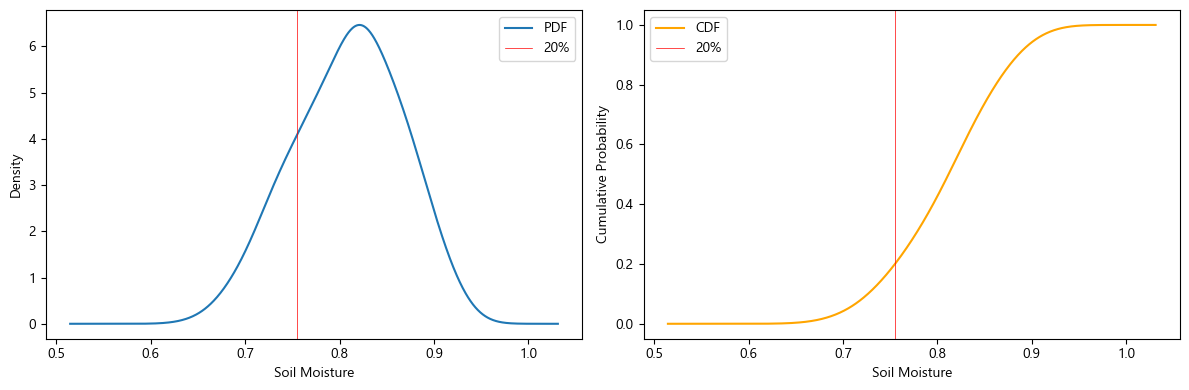

In [16]:
# Plot the PDF and CDF
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, prob_density, label='PDF')
plt.axvline(sm_02, color='red', lw=0.5, label='20%')
plt.xlabel('Soil Moisture')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, cdf, label='CDF', color='orange')
plt.axvline(sm_02, color='red', lw=0.5, label='20%')
#fill between the x values up to the threshold value
plt.fill_between(x, cdf, where=(x <= sm_02), color='red', alpha=0.)

plt.xlabel('Soil Moisture')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.tight_layout()
plt.show()

### Spatial cumulative distribution functions

In [17]:
#Period of interest. In this case, summer months
summer_months = [6,7,8]
#extract values for summer months
data_summer = mhm_fluxes_mon.sel(time=mhm_fluxes_mon.time.dt.month.isin(summer_months))

#average soil moisture for summer months for each year
data_summer_avg = data_summer.groupby('time.year').mean()

In [ ]:
data_summer

In [ ]:
variable = 'SM_L02'
# Define the x-axis range for KDE (fixed for consistency across grid cells)
cdf_length = 200  # Number of points for the CDF
cdf_x = None  # To store the x-axis values for the CDF (soil moisture range)

# Initialize a 3D array for storing the CDFs
cdf_array = np.full((len(data_summer_avg.lat), len(data_summer_avg.lon), cdf_length), np.nan)

# Loop through the grid cells
for i in range(len(data_summer_avg.lon)):  # Longitude dimension
    for j in range(len(data_summer_avg.lat)):  # Latitude dimension
        # Extract the time series for the current grid cell
        sample_ts = data_summer_avg[variable].sel(
            lon=data_summer_avg.lon[i], 
            lat=data_summer_avg.lat[j], 
            method='nearest'
        )
        ts_df = sample_ts.to_dataframe()
        soil_moisture = ts_df[variable].values

        # Skip cells with all NaN values
        if np.isnan(soil_moisture).all():
            continue

        # Compute optimal bandwidth for KDE
        bandwidths = np.linspace(0.001, 0.9, 200)
        optimal_h = compute_optimal_h(soil_moisture, bandwidths)

        # Perform KDE
        kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
        kde.fit(soil_moisture[:, None])

        # Define x-axis range for CDF
        if cdf_x is None:  # Initialize x-axis range if not already set
            cdf_x = np.linspace(soil_moisture.min() * 0.8, soil_moisture.max() * 1.1, cdf_length)

        logprob = kde.score_samples(cdf_x[:, None])
        prob_density = np.exp(logprob)

        # Compute the CDF
        cdf = np.cumsum(prob_density) * (cdf_x[1] - cdf_x[0])

        # Store the CDF in the corresponding grid cell
        cdf_array[j, i, :] = cdf

### Spatial Soil Moisture Index

In [175]:
drought_threshold = 0.2
time_steps = data_summer_avg.year.size

# Initialize a 2D array for storing drought status and percentiles
drought_map = np.full((time_steps, len(data_summer_avg.lat), len(data_summer_avg.lon)), np.nan)  # 3D array for drought status
percentile_map = np.full((time_steps, len(data_summer_avg.lat), len(data_summer_avg.lon)), np.nan)  # Percentile rank

# Loop through the grid cells
for i in range(len(data_summer_avg.lon)):
    for j in range(len(data_summer_avg.lat)):
        # Extract the historical CDF for the grid cell
        cdf = cdf_array[j, i, :]
        if np.isnan(cdf).all():  # Skip cells with no CDF data
            continue

        # Loop through each timestep
        for t in range(time_steps):
            # Get the soil moisture at the current timestep
            current_sm = data_summer_avg[variable].isel(lon=i, lat=j, year=t).values

            # Skip NaN values
            if np.isnan(current_sm):
                continue
            # Find the percentile rank of the current soil moisture in the CDF
            percentile_rank = np.interp(current_sm, cdf_x, cdf)  # Linear interpolation to find percentile
            percentile_map[t, j, i] = percentile_rank

            # Classify as drought if below the threshold
            if percentile_rank < drought_threshold:
                drought_map[t, j, i] = 1  # Drought
            else:
                drought_map[t, j, i] = 0  # No drought

In [348]:
drought_data = xr.DataArray(
    data=drought_map,
    coords={"time":data_summer_avg.year.values, "lat": data_summer_avg.lat.values, "lon": data_summer_avg.lon.values},
    dims=["time","lat", "lon"]
)

percentile_data = xr.DataArray(
    data=percentile_map,
    coords={"time":data_summer_avg.year.values, "lat": data_summer_avg.lat.values, "lon": data_summer_avg.lon.values},
    dims=["time","lat", "lon"]
)

In [304]:
cdf_data = xr.DataArray(
    data=cdf_array,
    coords={"lat": data_summer_avg.lat.values, "lon": data_summer_avg.lon.values, "cdf_x": cdf_x},
    dims=[ "lat", "lon", "cdf_x"]
)

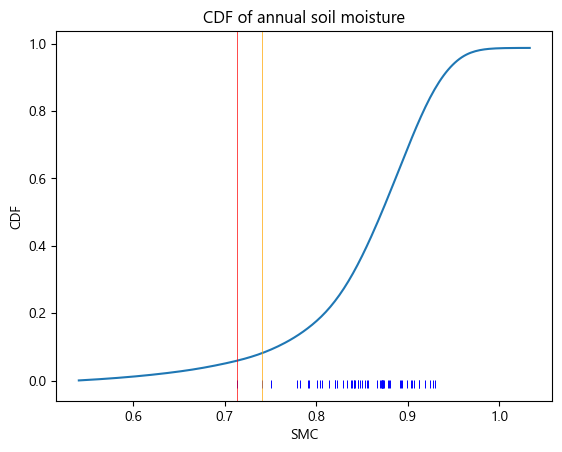

In [326]:
#extract sm values for the selected grid cell
sample_ts = data_summer_avg['SM_L02'].mean(dim =['lat', 'lon'])
ts_df = sample_ts.to_dataframe()
soil_moisture = ts_df['SM_L02'].values

plt.plot(cdf_x, cdf_data.mean(dim=['lat','lon']))
#plot soil moisture values
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.7)

#plot average soil moisture for 1976
plt.axvline(data_summer_avg['SM_L02'][6].mean(dim =['lat', 'lon']), color='red', lw=0.5)
plt.axvline(data_summer_avg['SM_L02'][50].mean(dim =['lat', 'lon']), color='orange', lw=0.5)

plt.title("CDF of annual soil moisture")
plt.xlabel("SMC")
plt.ylabel("CDF")
plt.show()

In [352]:
#subset where data < 0.2
drought_data_subset = percentile_data.where(percentile_data < 0.2)

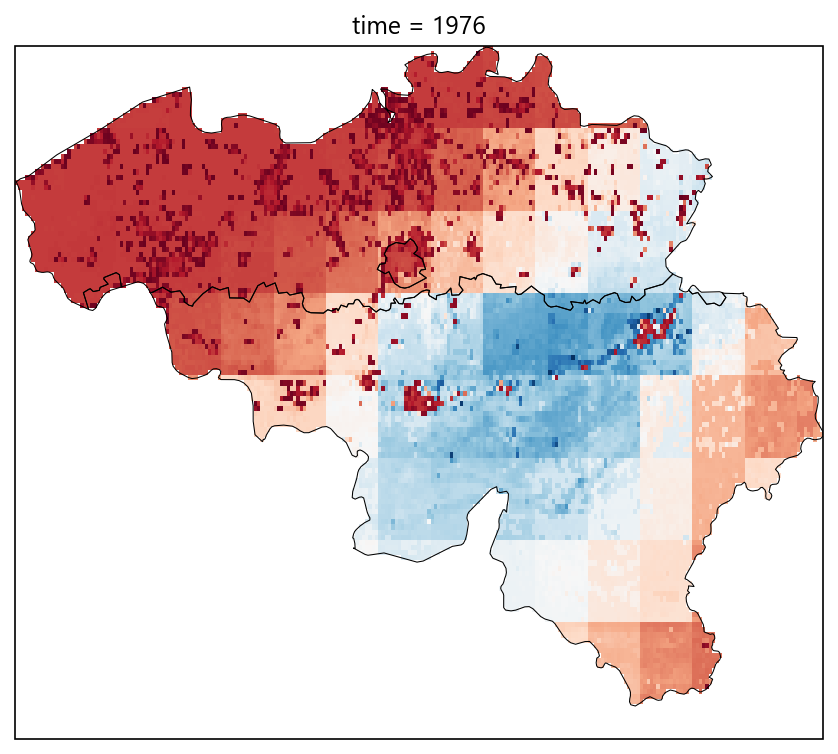

In [357]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6), dpi=150)
drought_data_subset[6].plot(ax=ax, cmap='RdBu', add_colorbar=False)
be_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5);

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3.5))
percentile_data.sel(lat=50.5, lon=4.5, method='nearest').plot(ax=ax)
percentile_data.sel(lat=51.1, lon=3.0, method='nearest').plot(ax=ax)
#plot line at y=0.2
plt.axhline(y=0.2, color='r', linestyle='--')

### Stacked area charts

C:\Users\kart\AppData\Local\Temp\ipykernel_31812\1529719508.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(start='2000-01-01', periods=10, freq='Y')  # 10 years


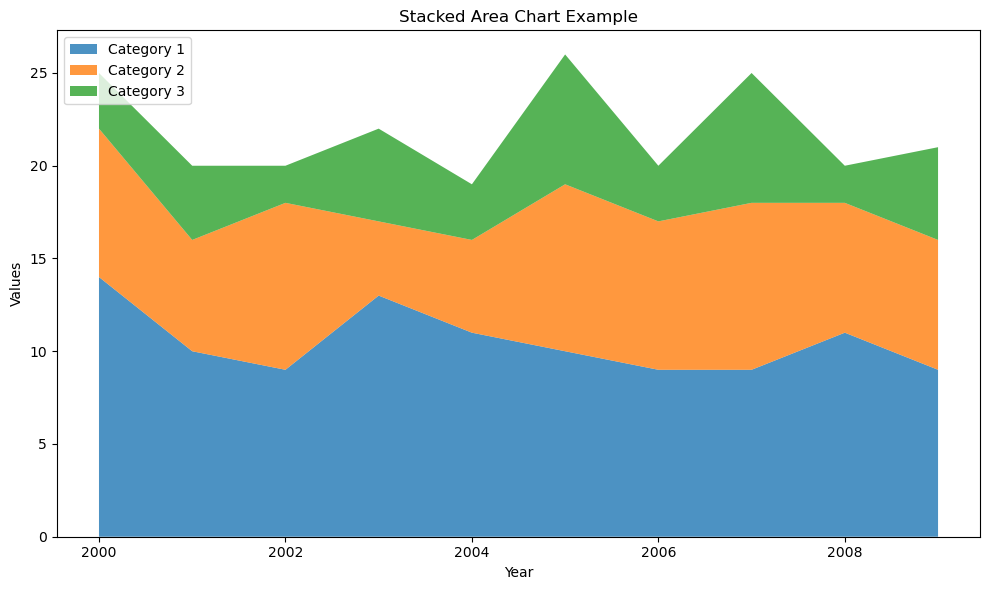

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example Data
dates = pd.date_range(start='2000-01-01', periods=10, freq='Y')  # 10 years
category_1 = np.random.randint(5, 15, len(dates))  # Random data for Category 1
category_2 = np.random.randint(3, 10, len(dates))  # Random data for Category 2
category_3 = np.random.randint(2, 8, len(dates))   # Random data for Category 3

# Combine data into a DataFrame
data = pd.DataFrame({
    'Year': dates.year,  # Use year as the x-axis
    'Category 1': category_1,
    'Category 2': category_2,
    'Category 3': category_3
})

# Plot a stacked area chart
fig, ax = plt.subplots(figsize=(10, 6))

# Use the "stackplot" function
ax.stackplot(
    data['Year'],  # x-axis: Year
    data['Category 1'],  # y-values: Category 1
    data['Category 2'],  # y-values: Category 2
    data['Category 3'],  # y-values: Category 3
    labels=['Category 1', 'Category 2', 'Category 3'],
    alpha=0.8  # Transparency
)

# Customize the chart
ax.set_title("Stacked Area Chart Example")
ax.set_xlabel("Year")
ax.set_ylabel("Values")
ax.legend(loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()


In [33]:
# Function to compute CDF for a single grid cell
def compute_cdf_vectorized(soil_moisture_timeseries, cdf_length, compute_optimal_h):
    # Convert the input to a NumPy array
    soil_moisture_timeseries = np.array(soil_moisture_timeseries).flatten()

    # Remove NaN values
    soil_moisture_timeseries = soil_moisture_timeseries[~np.isnan(soil_moisture_timeseries)]

    # Check if there are enough valid data points
    if len(soil_moisture_timeseries) > 1:
        try:
            # Compute the optimal bandwidth for KDE
            bandwidths = np.linspace(0.001, 0.9, 100)
            optimal_h = compute_optimal_h(soil_moisture_timeseries, bandwidths)

            # Fit Kernel Density Estimation (KDE)
            kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
            kde.fit(soil_moisture_timeseries[:, None])

            # Define the x-axis range for the CDF
            x = np.linspace(soil_moisture_timeseries.min() * 0.8, soil_moisture_timeseries.max() * 1.1, cdf_length)

            # Evaluate the PDF
            logprob = kde.score_samples(x[:, None])
            prob_density = np.exp(logprob)

            # Compute the CDF
            cdf = np.cumsum(prob_density) * (x[1] - x[0])

            return cdf  # Return the full CDF array
        except Exception as e:
            print(f"Error encountered: {e}")
            return np.full(cdf_length, np.nan)  # Return NaN array in case of an error
    else:
        # Not enough valid data points
        return np.full(cdf_length, np.nan)

# Main function to compute CDF for all grid cells
def compute_cdf_all_cells(data_summer_avg, variable, cdf_length, compute_optimal_h):
    # Extract the variable (e.g., soil moisture)
    data = data_summer_avg[variable]

    # Create a mask for valid grid cells (those with enough non-NaN values along the 'time' dimension)
    valid_mask = data.notnull().sum(dim='time') > 1

    # Apply the vectorized function to valid grid cells
    cdf_array = xr.apply_ufunc(
        compute_cdf_vectorized,  # The vectorized function
        data.where(valid_mask),  # Mask out invalid grid cells
        cdf_length,  # Number of points for the CDF
        compute_optimal_h,  # Function to compute the optimal KDE bandwidth
        input_core_dims=[['time'], [], []],  # The 'time' dimension is used for each grid cell
        output_core_dims=[['cdf']],  # The output will have a new 'cdf' dimension
        vectorize=True,  # Vectorize the operation
        output_sizes={'cdf': cdf_length},  # Specify the size of the 'cdf' dimension
        dask="parallelized",  # Enable parallel computation with Dask
        output_dtypes=[float],  # The output data type is float
    )

    return cdf_array

# Example usage
variable = "SM_L02"  # Soil moisture variable
cdf_length = 200  # Number of points for the CDF

#data_summer_avg = data_summer_avg.rename({'year':'time'})
# Compute the CDF for all grid cells
cdf_array = compute_cdf_all_cells(data_summer_avg, variable, cdf_length, compute_optimal_h)

# Check the result
print(cdf_array)

C:\Users\kart\AppData\Local\Temp\ipykernel_31812\3312511842.py:51: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  cdf_array = xr.apply_ufunc(


<xarray.DataArray 'SM_L02' (lat: 128, lon: 247, cdf: 200)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, 